1. The training data is based on the Wortschatz Corpora:
https://corpora.uni-leipzig.de/en?corpusId=deu_newscrawl-public_2018
2. The test data is based on the Euro Parliament Parallel Corpus:
http://www.statmt.org/europarl/

In [1]:
# To know how much RAM we get.. TPU gives the most. This was needed to read all the test files (euro parliament)
!cat /proc/meminfo | grep MemTotal

MemTotal:       350813624 kB


In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import string
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
class DatasetLoader:
    def __init__(self, folder, data_type='train', num_test_samples_per_class=10000):
        self.path_folder = folder
        self.data_type = data_type
        self.num_test_samples_per_class = num_test_samples_per_class
        # Dictionary to translate from non latin to latin
        self.non_latin_to_latin = {
            ord('á'): ord('a'), ord('à'): ord('a'), ord('ä'): ord('a'), ord('â'): ord('a'),
            ord('ã'): ord('a'), ord('å'): ord('a'), ord('ā'): ord('a'),
            ord('ç'): ord('c'),
            ord('é'): ord('e'), ord('è'): ord('e'), ord('ë'): ord('e'), ord('ê'): ord('e'),
            ord('ē'): ord('e'), ord('ė'): ord('e'), ord('ę'): ord('e'),
            ord('í'): ord('i'), ord('ì'): ord('i'), ord('ï'): ord('i'), ord('î'): ord('i'),
            ord('ī'): ord('i'),
            ord('ñ'): ord('n'),
            ord('ó'): ord('o'), ord('ò'): ord('o'), ord('ö'): ord('o'), ord('ô'): ord('o'),
            ord('õ'): ord('o'), ord('ø'): ord('o'), ord('ō'): ord('o'),
            ord('ú'): ord('u'), ord('ù'): ord('u'), ord('ü'): ord('u'), ord('û'): ord('u'),
            ord('ū'): ord('u'),
            ord('ý'): ord('y'), ord('ÿ'): ord('y'),
            ord('æ'): ord('a'), ord('œ'): ord('o'),
            ord('ß'): ord('s'),
            ord('þ'): ord('t'), ord('ð'): ord('d'),
            ord('č'): ord('c'), ord('ć'): ord('c'),
            ord('š'): ord('s'), ord('ś'): ord('s'),
            ord('ž'): ord('z'), ord('ź'): ord('z'), ord('ż'): ord('z'),
            ord('ł'): ord('l'),
            ord('đ'): ord('d'),
            ord('€'): ord('E'),
            ord('©'): ord('C'),

            # Bulgarian Cyrillic to Latin
            ord('а'): 'a', ord('б'): 'b', ord('в'): 'v', ord('г'): 'g',
            ord('д'): 'd', ord('е'): 'e', ord('ж'): 'z', ord('з'): 'z',
            ord('и'): 'i', ord('й'): 'y', ord('к'): 'k', ord('л'): 'l',
            ord('м'): 'm', ord('н'): 'n', ord('о'): 'o', ord('п'): 'p',
            ord('р'): 'r', ord('с'): 's', ord('т'): 't', ord('у'): 'u',
            ord('ф'): 'f', ord('х'): 'h', ord('ц'): 'c', ord('ч'): 'ch',
            ord('ш'): 'sh', ord('щ'): 'sht', ord('ъ'): 'a', ord('ь'): 'y',
            ord('ю'): 'yu', ord('я'): 'ya',

            # Greek to Latin
            ord('α'): 'a', ord('β'): 'b', ord('γ'): 'g', ord('δ'): 'd',
            ord('ε'): 'e', ord('ζ'): 'z', ord('η'): 'i', ord('θ'): 'th',
            ord('ι'): 'i', ord('κ'): 'k', ord('λ'): 'l', ord('μ'): 'm',
            ord('ν'): 'n', ord('ξ'): 'x', ord('ο'): 'o', ord('π'): 'p',
            ord('ρ'): 'r', ord('σ'): 's', ord('τ'): 't', ord('υ'): 'y',
            ord('φ'): 'f', ord('χ'): 'ch', ord('ψ'): 'ps', ord('ω'): 'o',
            ord('ά'): 'a', ord('έ'): 'e', ord('ή'): 'i', ord('ί'): 'i',
            ord('ό'): 'o', ord('ύ'): 'y', ord('ώ'): 'o', ord('ς'): 's',
            ord('ϊ'): 'i', ord('ΰ'): 'y', ord('ϋ'): 'y', ord('ΐ'): 'i',
        }

    def preprocess_text(self, text):
        text = (text.translate(self.non_latin_to_latin)).translate(str.maketrans('','',string.punctuation))
        text = loader.remove_leading_numbers(text)  # Remove leading numbers

        for i in ['"','„','”','’']:
            text.replace(i,'')

        return text.lower()

    # Function to remove numbers at the beginning of each line
    def remove_leading_numbers(self, text):
        lines = text.splitlines()  # Split text into lines
        cleaned_lines = []
        for line in lines:
            # Remove leading numbers and any following tabs/spaces
            cleaned_line = line.lstrip("0123456789\t ")
            cleaned_lines.append(cleaned_line)
        return "\n".join(cleaned_lines)

    # Function to split dataset
    def split_dataset(self, dataset):
        tr_set, test_set = train_test_split(dataset,test_size=0.2)
        tr_set,val_set =  train_test_split(tr_set,test_size = 0.1)
        return tr_set, val_set, test_set

    # Function to load dataset
    def load_dataset(self):

        dataset = []

        # Processing for training data
        if self.data_type == 'train':
          # Iterate through all folders inside the training folder
          for folder_name in os.listdir(self.path_folder):
              folder_path = os.path.join(self.path_folder, folder_name)

              # Skip if not a directory for training
              if not os.path.isdir(folder_path):
                  continue

              # Extract the label from the first three characters of the folder name
              label = folder_name[:3]

              # Process each file in the folder
              for file_name in os.listdir(folder_path):
                  # only files containing "sentences" in their name
                  if "sentences" in file_name:
                      file_path = os.path.join(folder_path, file_name)
                      # read the file and add its content to the dataset with the label
                      with open(file_path, 'r', encoding='utf-8') as file:
                          for line in file:
                              line = line.strip()
                              if line:  # Skip empty lines
                                  # preprocessing: from non latin to latin
                                  preprocessed_line = self.preprocess_text(line)
                                  dataset.append((label, preprocessed_line))

        # Processing for testing data... takes a lot of time..
        if self.data_type == 'test':
          label_dict = {'lv':'lav', 'fr':'fra', 'de':'deu', 'fi':'fin', 'it':'ita', 'et':'est', 'en':'eng', 'hu':'hun', 'sl':'slv', 'cs':'ces', 'pl':'pol', 'es':'spa', 'sv':'swe', 'ro':'ron', 'lt':'lit', 'sk':'slk', 'nl':'nld', 'da':'dan', 'pt':'por', 'el':'ell', 'bg':'bul'}
          # Process each file in the tetsing folder
          for file_name in os.listdir(self.path_folder):
            print(f'file_name being processed: {file_name}')
            # Extract the label from the 5 and 6 characters from right of the file name
            label_fn = file_name[-6:-4]
            label = label_dict[label_fn]  # Convert the label to 3 chars, to make labels same as used in training
            count = 0
            # only files containing "europarl" in their name
            if "europarl" in file_name:
                file_path = os.path.join(self.path_folder, file_name)
                # read the file and add its content to the dataset with the label
                with open(file_path, 'r', encoding='utf-8') as file:
                    for line in file:
                        line = line.strip()
                        if line:  # Skip empty lines
                            # preprocessing: from non latin to latin
                            count += 1
                            preprocessed_line = self.preprocess_text(line)
                            dataset.append((label, preprocessed_line))
                        # Limit the data per class
                        if count == self.num_test_samples_per_class:
                          #print(f'Breaking out of file {file_name}')
                          break

        return dataset


In [27]:
if __name__ == "__main__":
    # Training data
    training_folder = "/content/drive/My Drive/Data/Training"
    loader = DatasetLoader(training_folder)
    dataset = loader.load_dataset()
    tr_set, val_set, test_set = loader.split_dataset(dataset)

    # Print the first few examples to verify
    print("Training set examples:")
    for i, (label, sentence) in enumerate(tr_set[:5]):  # Display the first 5 entries of the training set
        print(f"Label: {label}, Sentence: {sentence}")

    print("\nValidation set examples:")
    for i, (label, sentence) in enumerate(val_set[:5]):  # Display the first 5 entries of the validation set
        print(f"Label: {label}, Sentence: {sentence}")

    print("\nTest set examples:")
    for i, (label, sentence) in enumerate(test_set[:5]):  # Display the first 5 entries of the test set
        print(f"Label: {label}, Sentence: {sentence}")

Training set examples:
Label: hun, Sentence: a korrupcio elleni harcra es a vallalati szervezetek visszaeleseire szakosodott public eye nevű svajci civil szervezet hetfőn ugy velekedett hogy a legutobbi birosagi ugy ravilagitott a svajci penzugyi felugyelet hianyossagaira
Label: ron, Sentence: atunci cand te blochezi la un punct de pe lista ta incearcă o abordare nouă schimbă locul de unde lucrezi ieși pe balcon sau in grădină pentru 5 minute fă un minut de exerciții sau recompenseazăte cu ceva dulce
Label: ron, Sentence: asta este natia americana nicidecum aia de la vocea americii europa libera sau alte oficine lansatoare de lozinci pentru babuini
Label: slk, Sentence: s prichodom horucav vyhlasili hasici zakaz kladenia ohňa vo viacerych oblastiach statu novy juzny wales ktory pocas minulorocneho leta zasiahli nicive poziare
Label: fin, Sentence: periaate koskee siis myos suomea vaikka siihen ei suoraan viitatakaan

Validation set examples:
Label: por, Sentence: ja ciro gomes pdt reun

In [28]:
print(type(tr_set))
print(type(tr_set[1]))

<class 'list'>
<class 'tuple'>


In [29]:
print((tr_set[1]))

('ron', 'atunci cand te blochezi la un punct de pe lista ta incearcă o abordare nouă schimbă locul de unde lucrezi ieși pe balcon sau in grădină pentru 5 minute fă un minut de exerciții sau recompenseazăte cu ceva dulce')


In [30]:
# Generate random HD vectors for tri-grams
def generate_hd_vectors(tri_grams, d):
    hd_vectors = {}
    for tg in tri_grams:
        if tg not in hd_vectors:
            hd_vectors[tg] = np.random.choice([-1, 1], size=d)
    return hd_vectors

# Extract tri-grams
def extract_tri_grams(text):
    return [text[i:i+3] for i in range(len(text) - 2)]

# Compute HD vector for a text
def compute_hd_vector(text, d, hd_vectors):
    tri_grams = extract_tri_grams(text)
    text_vector = np.zeros(d)
    for tg in tri_grams:
        text_vector += hd_vectors.get(tg, np.zeros(d))  # Add existing or empty vector
    return text_vector

"""
# Example Usage
sample_text = "language"
tri_grams = extract_tri_grams(sample_text)
hd_vectors = generate_hd_vectors(tri_grams, d=100)
text_vector = compute_hd_vector(sample_text, d=100, hd_vectors=hd_vectors)  # this is centroid

print("Tri-grams:", tri_grams)
print("Text HD vector:", text_vector)
print("Text HD vector length:", len(text_vector))
"""

'\n# Example Usage\nsample_text = "language"\ntri_grams = extract_tri_grams(sample_text)\nhd_vectors = generate_hd_vectors(tri_grams, d=100)\ntext_vector = compute_hd_vector(sample_text, d=100, hd_vectors=hd_vectors)  # this is centroid\n\nprint("Tri-grams:", tri_grams)\nprint("Text HD vector:", text_vector)\nprint("Text HD vector length:", len(text_vector))\n'

In [31]:
# Combine all the texts
all_texts = ' '.join([text for _, text in tr_set])
print(len(all_texts))

# Extract tri-grams for the combined text
tri_grams_all_texts = extract_tri_grams(all_texts)

# generate hd_vector for each tri_grams in the combined text
hd_vectors_all_texts = generate_hd_vectors(tri_grams_all_texts, d=1000)

49860562


In [32]:
# Example training data: [('English', 'This is a sentence'), ('French', 'Ceci est une phrase'), ...]
#train_data = [('English', 'This is a sentence'), ('French', 'Ceci est une phrase')]

# Compute centroids for each language
language_centroids = {}
d = 1000  # 1000 for higher dimensionality

# Group texts by language
texts_by_language = {}
for lang, text in tr_set:
    if lang not in texts_by_language:
        texts_by_language[lang] = []
    texts_by_language[lang].append(text)

# Compute centroids
for lang, texts in texts_by_language.items():
    lang_vector = np.zeros(d)
    for text in texts:
        lang_vector += compute_hd_vector(text, d=d, hd_vectors=hd_vectors_all_texts)
    language_centroids[lang] = lang_vector

print("Language Centroids:", language_centroids.keys())
#print("Language Centroids:", language_centroids.values())


Language Centroids: dict_keys(['hun', 'ron', 'slk', 'fin', 'pol', 'slv', 'lav', 'ces', 'deu', 'ell', 'lit', 'dan', 'ita', 'spa', 'bul', 'eng', 'est', 'fra', 'por', 'nld', 'swe'])


In [33]:
# Classification function
def classify_language(test_text, language_centroids, d, hd_vectors):
    query_vector = compute_hd_vector(test_text, d, hd_vectors)
    similarities = {}
    for lang, centroid in language_centroids.items():

        query_norm = np.linalg.norm(query_vector)
        centroid_norm = np.linalg.norm(centroid)

        # Avoid division by zero
        if query_norm == 0 or centroid_norm == 0:
            similarities[lang] = float('-inf')  # Assign a very low similarity
            continue

        # Calculate cosine similarity
        cosine_sim = np.dot(query_vector, centroid) / (query_norm * centroid_norm)
        similarities[lang] = cosine_sim
        #cosine_sim = np.dot(query_vector, centroid) / (np.linalg.norm(query_vector) * np.linalg.norm(centroid))
        #similarities[lang] = cosine_sim
    return max(similarities, key=similarities.get)

Accuracy: 0.9394642857142858
F1-Score: 0.9394189569386324


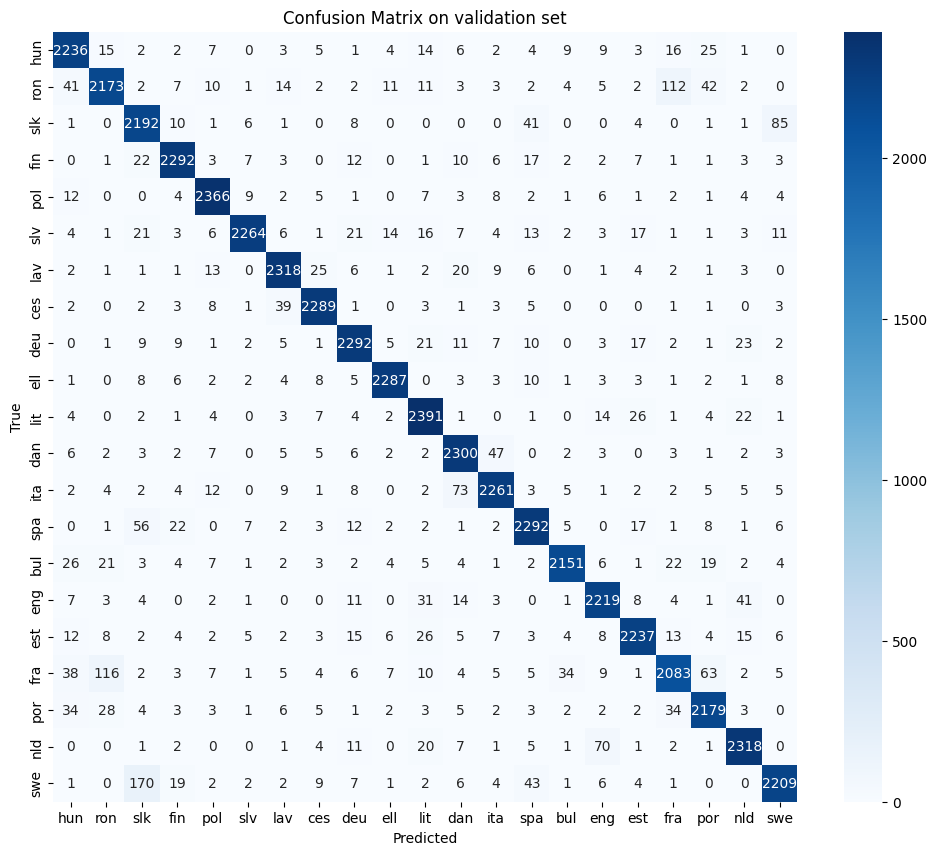

In [34]:
# Evaluate on validation data
predictions = []
true_labels = []

for label, text in val_set:
    pred = classify_language(text, language_centroids, d=1000, hd_vectors=hd_vectors_all_texts)
    predictions.append(pred)
    true_labels.append(label)

# Confusion Matrix and Metrics
conf_matrix = confusion_matrix(true_labels, predictions)
accuracy = accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions, average='weighted')

#print("Confusion Matrix:\n", conf_matrix)
print("Accuracy:", accuracy)
print("F1-Score:", f1)

# Plot Confusion Matrix
labels = list(language_centroids.keys())
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on validation set')
plt.show()

Accuracy on test set: 0.939015873015873
F1-Score on test set: 0.9389180364246025


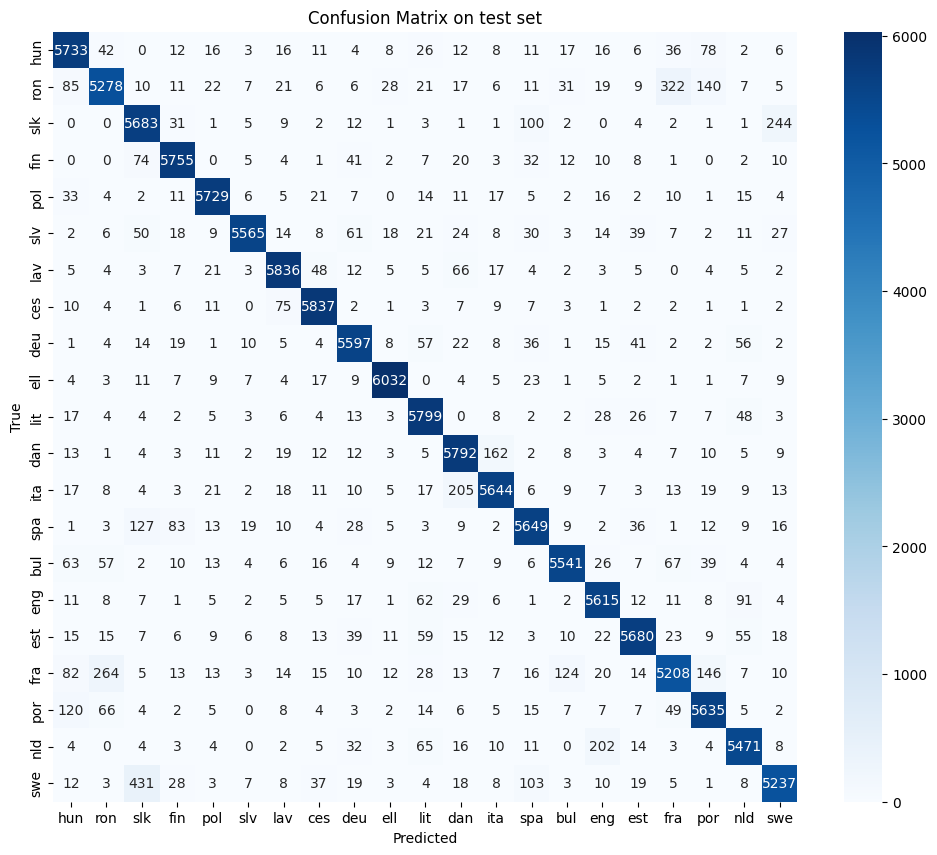

In [35]:
# Evaluate on test set
predictions = []
true_labels = []

for label, text in test_set:
    pred = classify_language(text, language_centroids, d=1000, hd_vectors=hd_vectors_all_texts)
    predictions.append(pred)
    true_labels.append(label)

# Confusion Matrix and Metrics
conf_matrix = confusion_matrix(true_labels, predictions)
accuracy = accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions, average='weighted')

#print("Confusion Matrix:\n", conf_matrix)
print("Accuracy on test set:", accuracy)
print("F1-Score on test set:", f1)

# Plot Confusion Matrix
labels = list(language_centroids.keys())
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on test set')
plt.show()

### Testing on European parliament data http://www.statmt.org/europarl/

In [36]:
# Testing data - European parliament data
testing_folder = "/content/drive/My Drive/Data/Testing"
num_test_samples_per_class = 50000  # Limit the number of samples per class
loader = DatasetLoader(testing_folder,'test',num_test_samples_per_class)
test_dataset = loader.load_dataset()


# Print the first few examples to verify
print("\nTest dataset examples from europarl:")
for i, (label, sentence) in enumerate(test_dataset[:5]):  # Display the first 5 entries of the test set
    print(f"Label: {label}, Sentence: {sentence}")

print(type(test_dataset[1]))
print(test_dataset[1])

file_name being processed: europarl-v7.cs-en.cs.txt
file_name being processed: europarl-v7.de-en.de.txt
file_name being processed: europarl-v7.es-en.es.txt
file_name being processed: europarl-v7.fr-en.fr.txt
file_name being processed: europarl-v7.ro-en.ro.txt
file_name being processed: europarl-v7.bg-en.bg.txt
file_name being processed: europarl-v7.sl-en.sl.txt
file_name being processed: europarl-v7.hu-en.hu.txt
file_name being processed: europarl-v7.pl-en.pl.txt
file_name being processed: europarl-v7.et-en.et.txt
file_name being processed: europarl-v7.lt-en.lt.txt
file_name being processed: europarl-v7.sk-en.sk.txt
file_name being processed: europarl-v7.lv-en.lv.txt
file_name being processed: europarl-v7.el-en.el.txt
file_name being processed: europarl-v7.sv-en.sv.txt
file_name being processed: europarl-v7.fi-en.fi.txt
file_name being processed: europarl-v7.it-en.it.txt
file_name being processed: europarl-v7.pt-en.pt.txt
file_name being processed: europarl-v7.da-en.da.txt
file_name be

In [37]:
print(type(test_dataset[1]))
print(test_dataset[1])
print(len(test_dataset))

<class 'tuple'>
('ces', 'předlozeni dokumentů viz zapis')
1050000


In [38]:
# Just checking some random files..
count = 0
for i, (label, text) in enumerate(test_dataset):
  # This was to restrict number of test cases to be classified.. But now implemneted to have limited data per class in the preprocessing.
  if label == 'bul':
    print(text)
    count += 1
    if count == 5:
      break

сastav na пarlamenta vz protokoli
оdobryavane na protokola ot predishnoto zasedanie vz protokolite
сastav na пarlamenta vz protokoli
пroverka na palnomoshtiyata vz protokoli
вnasyane na dokumenti vz protokoli


Accuracy on test set: 0.9392114285714286
F1-Score on test set: 0.9392117076082653


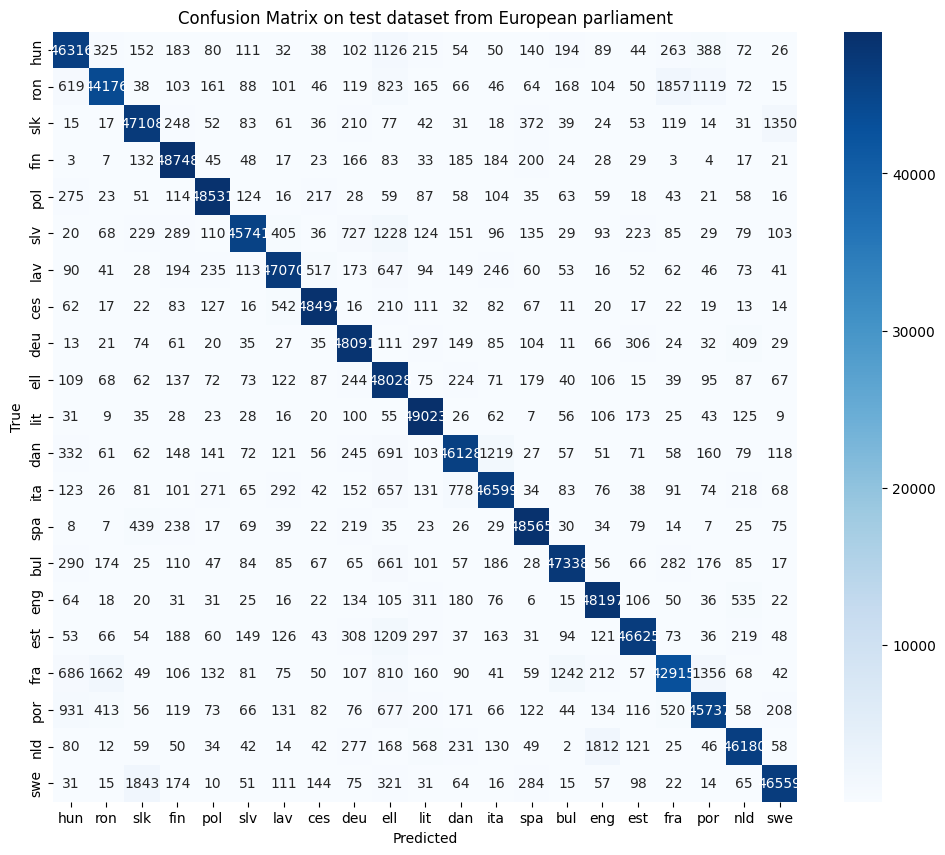

In [39]:
# Evaluate on test datset from european parliament (europarl)
predictions = []
true_labels = []

for i, (label, text) in enumerate(test_dataset):
  pred = classify_language(text, language_centroids, d=1000, hd_vectors=hd_vectors_all_texts)
  predictions.append(pred)
  true_labels.append(label)

# Confusion Matrix and Metrics
conf_matrix = confusion_matrix(true_labels, predictions)
accuracy = accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions, average='weighted')

#print("Confusion Matrix:\n", conf_matrix)
print("Accuracy on test set:", accuracy)
print("F1-Score on test set:", f1)

# Plot Confusion Matrix
labels = list(language_centroids.keys())
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on test dataset from European parliament')
plt.show()